# Purpose:
- Develop codes for matching ROIs between sessions
- Between 2 sessions or more

## Background:
- roi_collection_across_sessions.py
- Creates JK0xx_plane_y_cellpose_master_roi.npy, and _cellpose_roi_session_to_master.npy
    - Don't know where JK0xx_plane_y_cellpose_roi_collection.npy comes from...
    - _cellpose_master_roi.npy:
        - viable cell index (index from iscell.npy per session)
        - session map list (ROI map of each viable cell - ordered the same as viable cell index)
        - master map (the last in the list the final master map)
        - session_nums
    - _cellpose_roi_session_to_master.npy:
        - 2d array, matching each cell in the master map index to the index of viable cell index of each session.


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

base_dir = Path(r'E:\TPM\JK\h5')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]

In [69]:
def get_matched_roi_inds_ordered(base_dir, mouse, plane, sessions):
    """ Get the indices of the ROIs that are matched across sessions and ordered by the master ROI index.
    
    Args:
    base_dir: Path
        The base directory where the data is stored
    mouse: int
        The mouse number
    plane: int
        The plane number
    sessions: list
        The list of session numbers
        
    Returns:
    roi_ind_matched_ordered: list
        The list of indices of the ROIs that are matched across sessions and ordered by the master ROI index.
        These indices are matched to spks, stats, and iscell.npy
    """
    plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
    master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
    master_roi_results = np.load(master_roi_fn, allow_pickle=True).item()
    session_inds_master_roi = [np.where(np.array(master_roi_results['session_nums']) == sn)[0][0] for sn in sessions]

    roi_matching_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_session_to_master.npy'
    roi_matching = np.load(roi_matching_fn, allow_pickle=True).item()

    session_to_master = []
    for si in session_inds_master_roi:
        session_to_master.append(roi_matching['matching_master_roi_index_list'][si])

    matched_master_roi_inds = np.intersect1d(*session_to_master)
    roi_ind_matched_ordered = []
    if len(matched_master_roi_inds) > 0:        
        viable_cell_index = [master_roi_results['viable_cell_index_list'][si] for si in session_inds_master_roi]
        for si in range(len(session_to_master)):
            viable_ind_matched_ordered = np.array([np.where(session_to_master[si]==ri)[0][0] for ri in matched_master_roi_inds])
            roi_ind_matched_ordered.append(np.array([viable_cell_index[si][i] for i in viable_ind_matched_ordered]))
    return roi_ind_matched_ordered


# Dev

In [10]:
mi = 0
mouse = mice[mi]
plane = 1

plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi_results = np.load(master_roi_fn, allow_pickle=True).item()
sessions = test_sessions[mi]
session_inds_master_roi = [np.where(np.array(master_roi_results['session_nums']) == sn)[0][0] for sn in sessions]

In [19]:
roi_matching_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_session_to_master.npy'
roi_matching = np.load(roi_matching_fn, allow_pickle=True).item()

In [21]:
session_to_master = []
for si in session_inds_master_roi:
    session_to_master.append(roi_matching['matching_master_roi_index_list'][si])

In [22]:
session_to_master[0]

array([ 90,  57,  37,  91,  92,  20, 214,  38,  63,  93,  39,  21,  94,
        95,  96, 141,  97,  98,  99, 315,  44, 149, 209,  45, 100, 101,
       242, 102, 103, 104,  46, 223, 105, 106, 107, 108, 109,   3, 251,
       110, 111,   6, 112,  54, 113, 114,  23, 174,  40, 256, 115,  51,
        55, 116, 117, 118, 119, 120, 162,  16, 121, 144, 245,  35,  42,
       122,  81, 123, 124, 152,  30, 284, 125, 126, 127, 178,  26,  10,
       235,  28, 128,  17, 129,  70, 314, 150, 130, 184, 131, 132, 300,
       247, 299,   1, 133,  67, 134, 135, 136, 304, 137, 138, 139,  18,
       261, 249], dtype=int64)

In [24]:
session_to_master[1]

array([220, 214, 166, 161, 290, 141, 223,  39, 188, 164,  17, 291, 292,
        41, 101, 293, 167,   2,  91,  70, 294, 123, 295, 177, 133,   6,
       149,  42, 296, 297, 298,  51, 160,  90, 299, 300,  32,  20,  14,
       301, 302, 303,  55, 118, 199, 194, 205, 263, 284,   3, 242, 304,
       120, 305, 240, 157,  11,  94, 115, 174,  40, 279, 306, 119, 104,
       264, 283, 307, 288, 245, 308, 228, 309,  31, 286, 310,  10, 131,
       252,  92, 156, 311, 112,  28, 312, 246, 109, 313,  57,  21, 314,
       315,  67, 249, 316,  23], dtype=int64)

In [41]:
matched_master_roi_inds = np.intersect1d(*session_to_master)


In [27]:
master_roi_results.keys()

dict_keys(['master_map_list', 'session_map_list', 'viable_cell_index_list', 'new_master_map_list', 'new_map_list', 'session_nums'])

In [29]:
viable_cell_index = [master_roi_results['viable_cell_index_list'][si] for si in session_inds_master_roi]

In [30]:
viable_cell_index[0]

array([  0,   1,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,
        15,  16,  17,  19,  21,  22,  25,  27,  28,  29,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  49,
        50,  51,  52,  54,  55,  56,  57,  58,  60,  61,  62,  63,  66,
        67,  68,  69,  71,  72,  73,  74,  78,  79,  80,  81,  82,  83,
        84,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 114, 115,
       116, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131,
       132, 133], dtype=int64)

In [31]:
viable_cell_index[1]

array([  1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  13,  14,  15,
        16,  18,  24,  26,  27,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  43,  44,  48,  49,  50,  51,  53,  55,
        56,  58,  60,  62,  63,  64,  65,  66,  68,  69,  70,  71,  72,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  94,  96,  97,  98,  99, 102, 103, 104,
       105, 107, 108, 110, 111, 113, 115, 116, 117, 118, 119, 120, 122,
       123, 124, 125, 126, 127], dtype=int64)

In [33]:
session = sessions[0]
roi_dir = plane_dir / f'{session:03}/plane0/roi'
spikes = np.load(roi_dir / 'spks_reduced.npy')
iscell = np.load(roi_dir / 'iscell.npy')

In [35]:
len(viable_cell_index[0])

106

In [34]:
spikes.shape

(134, 9909)

In [36]:
iscell.shape

(134, 2)

In [45]:
np.where(np.isin(session_to_master[0], matched_master_roi_inds))[0]

array([  0,   1,   3,   4,   5,   6,  10,  11,  12,  15,  19,  21,  25,
        26,  29,  31,  36,  37,  41,  42,  46,  47,  48,  50,  51,  52,
        55,  56,  57,  62,  64,  67,  71,  77,  79,  81,  83,  84,  88,
        90,  92,  94,  95,  99, 105], dtype=int64)

In [47]:
session_maps = [master_roi_results['session_map_list'][si] for si in session_inds_master_roi]
matched_session_maps = []
for i in range(len(session_inds_master_roi)):
    session_roi_inds_matched = np.where(np.isin(session_to_master[i], matched_master_roi_inds))[0]
    matched_session_maps.append(session_maps[i][session_roi_inds_matched,:,:])

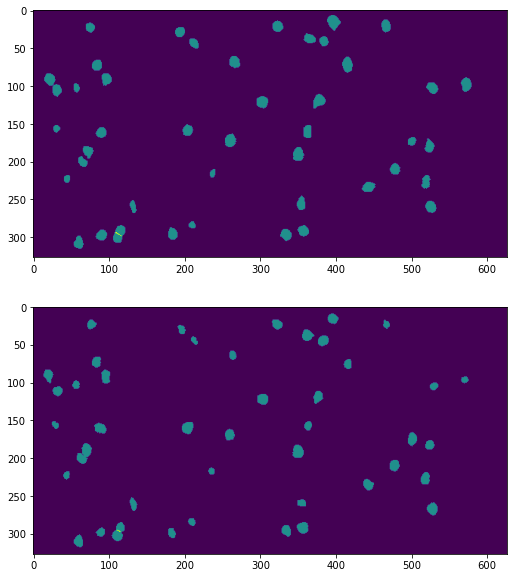

In [49]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(matched_session_maps[0].sum(axis=0))
ax[1].imshow(matched_session_maps[1].sum(axis=0))

In [50]:
matched_master_roi_inds

array([  3,   6,  10,  17,  20,  21,  23,  28,  39,  40,  42,  51,  55,
        57,  67,  70,  90,  91,  92,  94, 101, 104, 109, 112, 115, 118,
       119, 120, 123, 131, 133, 141, 149, 174, 214, 223, 242, 245, 249,
       284, 299, 300, 304, 314, 315], dtype=int64)

In [55]:
roi_ind_matched_ordered = []
for si in range(len(session_to_master)):
    viable_ind_matched_ordered = np.array([np.where(session_to_master[si]==ri)[0][0] for ri in matched_master_roi_inds])
    roi_ind_matched_ordered.append(np.array([viable_cell_index[si][i] for i in viable_ind_matched_ordered]))


In [54]:
import napari

In [59]:
stats = []
for session in sessions:
    roi_dir = plane_dir / f'{session:03}/plane0/roi'
    stat = np.load(roi_dir / 'stat_refined.npy', allow_pickle=True)
    stats.append(stat)

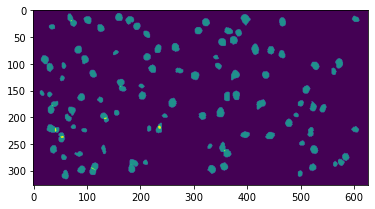

In [64]:
plt.imshow(master_roi_results['session_map_list'][3].sum(axis=0))

In [65]:
ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()


In [67]:
matched_roi_maps = np.zeros((len(sessions), len(matched_master_roi_inds), ops['Ly'], ops['Lx']))

for si in range(len(session_inds_master_roi)):
    for ri in range(len(matched_master_roi_inds)):
        x = stats[si][roi_ind_matched_ordered[si][ri]]['xpix']
        y = stats[si][roi_ind_matched_ordered[si][ri]]['ypix']
        matched_roi_maps[si,ri,y,x] = 1

In [70]:
viewer = napari.Viewer()
viewer.add_image(matched_roi_maps[0])
viewer.add_image(matched_roi_maps[1], opacity=0.5)

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'Image [1]' at 0x2c20bf0a370>

# Test codes from matched_roi.py

In [75]:
# from importlib import reload
# reload(mr)

<module 'matched_roi' from 'c:\\Users\\shires\\Dropbox\\Works\\Projects\\2020 Neural stretching in S1\\Analysis\\codes\\data_analysis\\matched_roi.py'>

In [76]:
import matched_roi as mr
mouse = 25
plane = 3
sessions_all = np.array([int(sn) for sn in use_mice_df.query('mouse==@mouse and plane==@plane').session.unique()])
sessions = sessions_all[:3]

roi_ind_matched_ordered, matched_master_roi_inds = mr.get_matched_roi_inds_ordered(base_dir, mouse, plane, sessions)

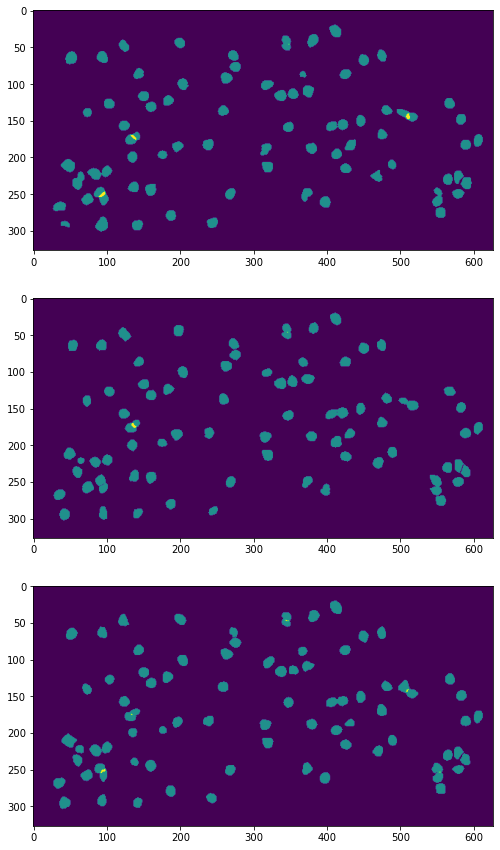

In [85]:
reload(mr)
fig, ax = mr.compare_group_matched_inds(base_dir, mouse, plane, sessions)

In [86]:
mr.compared_ordered_roi_matching_napari(base_dir, mouse, plane, sessions)

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


# Removing not-cells
- ROI collection and matching were done before dendrite filtering
- Additional filtering happened and recorded at iscell.npy
    - filter_dendrite_rois.py (diameter = 7)

In [41]:
mouse = 25
plane = 1
sessions = [4,19]

plane_dir = base_dir / f'{mouse:03}/plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi_results = np.load(master_roi_fn, allow_pickle=True).item()
session_inds_master_roi = [np.where(np.array(master_roi_results['session_nums']) == sn)[0][0] for sn in sessions]

roi_matching_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_session_to_master.npy'
roi_matching = np.load(roi_matching_fn, allow_pickle=True).item()



In [42]:
si = session_inds_master_roi[0]
print(len(roi_matching['matching_master_roi_index_list'][si]))
print(len(master_roi_results['viable_cell_index_list'][si]))

106
106


In [43]:
master_roi_results['viable_cell_index_list'][si]

array([  0,   1,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,
        15,  16,  17,  19,  21,  22,  25,  27,  28,  29,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  49,
        50,  51,  52,  54,  55,  56,  57,  58,  60,  61,  62,  63,  66,
        67,  68,  69,  71,  72,  73,  74,  78,  79,  80,  81,  82,  83,
        84,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 114, 115,
       116, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131,
       132, 133], dtype=int64)

In [44]:
roi_matching['matching_master_roi_index_list'][si]

array([ 90,  57,  37,  91,  92,  20, 214,  38,  63,  93,  39,  21,  94,
        95,  96, 141,  97,  98,  99, 315,  44, 149, 209,  45, 100, 101,
       242, 102, 103, 104,  46, 223, 105, 106, 107, 108, 109,   3, 251,
       110, 111,   6, 112,  54, 113, 114,  23, 174,  40, 256, 115,  51,
        55, 116, 117, 118, 119, 120, 162,  16, 121, 144, 245,  35,  42,
       122,  81, 123, 124, 152,  30, 284, 125, 126, 127, 178,  26,  10,
       235,  28, 128,  17, 129,  70, 314, 150, 130, 184, 131, 132, 300,
       247, 299,   1, 133,  67, 134, 135, 136, 304, 137, 138, 139,  18,
       261, 249], dtype=int64)

In [53]:
np.where(master_roi_results['viable_cell_index_list'][si]==37)

(array([29], dtype=int64),)

In [52]:
np.where(roi_matching['matching_master_roi_index_list'][si]==3)

(array([37], dtype=int64),)

In [51]:
matched_master_roi_inds

array([  3,   6,  17,  20,  21,  23,  39,  40,  42,  51,  55,  57,  67,
        70,  90,  91,  92,  94, 101, 104, 109, 115, 119, 120, 131, 133,
       141, 149, 174, 214, 223, 242, 249, 299, 300, 304, 315], dtype=int64)

In [6]:
i = 0
session = sessions[i]
roi_dir = plane_dir / f'{session:03}/plane0/roi'
iscell = np.load(roi_dir / 'iscell.npy')
iscell_inds = np.where(iscell[:,0])[0]


In [9]:
iscell_inds_viable_cell_index = np.where(np.isin(master_roi_results['viable_cell_index_list'][si],
                                                iscell_inds))[0]

In [14]:
roi_matching['matching_master_roi_index_list'][si][iscell_inds_viable_cell_index]

array([ 90,  57,  37,  91,  92,  20, 214,  38,  63,  93,  39,  21,  94,
        95,  96, 141,  97,  98,  99, 315,  44, 149, 209,  45, 100, 101,
       242, 102, 103, 104,  46, 223, 105, 106, 107, 109,   3, 251, 111,
         6, 112,  54, 114,  23, 174,  40, 256, 115,  51,  55, 116, 117,
       118, 119, 120, 162,  16, 144,  35,  42, 122,  81, 123, 126, 127,
        17, 129,  70, 150, 130, 131, 132, 300, 247, 299,   1, 133,  67,
       134, 136, 304, 137, 138, 139,  18, 261, 249], dtype=int64)

In [36]:
remove_notcell = True
session_to_master = []
for i, si in enumerate(session_inds_master_roi):
    if remove_notcell:
        session = sessions[i]
        roi_dir = plane_dir / f'{session:03}/plane0/roi'
        iscell = np.load(roi_dir / 'iscell.npy')
        iscell_inds = np.where(iscell[:,0])[0]
        iscell_inds_viable_cell_index = np.where(np.isin(master_roi_results['viable_cell_index_list'][si],
                                                        iscell_inds))[0]
    else:
        iscell_inds_viable_cell_index = range(len(master_roi_results['viable_cell_index_list'][si]))
    assert len(roi_matching['matching_master_roi_index_list'][si]) == len(master_roi_results['viable_cell_index_list'][si])
    session_to_master.append(roi_matching['matching_master_roi_index_list'][si][iscell_inds_viable_cell_index])

matched_master_roi_inds = session_to_master[0]
for si in range(1,len(sessions)):
    matched_master_roi_inds = np.intersect1d(matched_master_roi_inds, session_to_master[si])

print(len(matched_master_roi_inds))

37


In [54]:
roi_ind_matched_ordered = []
if len(matched_master_roi_inds) > 0:        
    viable_cell_index = [master_roi_results['viable_cell_index_list'][si] for si in session_inds_master_roi]
    session_to_master_again = [roi_matching['matching_master_roi_index_list'][si] for si in session_inds_master_roi]
    for si in range(len(sessions)):
        viable_ind_matched_ordered = np.array([np.where(session_to_master_again[si]==ri)[0][0] for ri in matched_master_roi_inds])
        session_roi_ind_matched_ordered = np.array([viable_cell_index[si][i] for i in viable_ind_matched_ordered])
        roi_ind_matched_ordered.append(session_roi_ind_matched_ordered)
        assert len(session_roi_ind_matched_ordered) == len(matched_master_roi_inds)

In [48]:
np.sort(roi_ind_matched_ordered[0])

array([  0,   1,   4,   5,   6,   7,  12,  13,  14,  17,  25,  28,  33,
        34,  37,  39,  43,  44,  50,  55,  56,  57,  60,  61,  62,  68,
        69,  78,  84,  88,  91,  93,  95,  97,  98, 102, 109], dtype=int64)

In [56]:
i = 0
session = sessions[i]
roi_dir = plane_dir / f'{session:03}/plane0/roi'
iscell = np.load(roi_dir / 'iscell.npy')
iscell_inds = np.where(iscell[:,0])[0]
np.isin(roi_ind_matched_ordered[i], iscell_inds).all()

True

In [ ]:
session_to_master = []
for si in session_inds_master_roi:
    session_to_master.append(roi_matching['matching_master_roi_index_list'][si])

matched_master_roi_inds = session_to_master[0]
for si in range(1,len(sessions)):
    matched_master_roi_inds = np.intersect1d(matched_master_roi_inds, session_to_master[si])

roi_ind_matched_ordered = []
if len(matched_master_roi_inds) > 0:
    viable_cell_index = [master_roi_results['viable_cell_index_list'][si] for si in session_inds_master_roi]
    session_to_master_again = [roi_matching['matching_master_roi_index_list'][si] for si in session_inds_master_roi]
    for si in range(len(sessions)):
        viable_ind_matched_ordered = np.array([np.where(session_to_master_again[si]==ri)[0][0] for ri in matched_master_roi_inds])
        roi_ind_matched_ordered.append(np.array([viable_cell_index[si][i] for i in viable_ind_matched_ordered]))
